# 利用GAN生成DeepFool对抗样本_picture-demo



In [1]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt

# 防止内存占用过大内核崩了
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

%matplotlib inline

E:\ANACONDA\envs\python374\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\ANACONDA\envs\python374\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\ANACONDA\envs\python374\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\ANACONDA\envs\python374\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarnin

# 导入数据

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

# image load
from tflearn.data_utils import image_preloader
from tflearn.data_utils import shuffle
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

train_dataset_file = './DeepFool_baleful_pngs.txt'
X,Y = image_preloader(train_dataset_file, image_shape=(9,9),mode='file',normalize=True, categorical_labels=True, grayscale=True)
X = shuffle(X)[0]

print(np.shape(X))

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
(60000, 9, 9, 1)


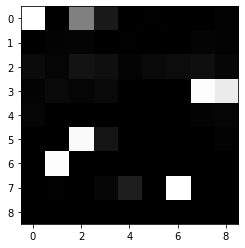

In [3]:
img = X[100]
# img = mnist.train.images[50]
plt.imshow(img.reshape((9, 9)), cmap='Greys_r')

# 构建模型

- inputs
- generator
- descriminator
- loss && optimizer

## Inputs

In [4]:
def get_inputs(real_size, noise_size):
    """
    真实图像tensor与噪声图像tensor
    """
    real_img = tf.placeholder(tf.float32, [None, real_size], name='real_img')
    noise_img = tf.placeholder(tf.float32, [None, noise_size], name='noise_img')
    
    return real_img, noise_img

## generator

In [5]:
def get_generator(noise_img, out_dim, n_units, reuse=False, alpha=0.01):
    """
    生成器
    
    noise_img: 生成器的输入
    out_dim: 生成器输出tensor的size，这里应该为9*9=81
    alpha: leaky ReLU系数
    """
    with tf.variable_scope("generator", reuse=reuse):
        
        # hidden layer
        hidden1 = tf.layers.dense(noise_img, n_units)
        
        # leaky ReLU
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        # logits & outputs
        logits = tf.layers.dense(hidden1, out_dim)
        outputs = tf.tanh(logits, name='gen_output')
        
        return logits, outputs

## Discriminator

In [6]:
# image load
from tflearn.data_utils import image_preloader
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

# network build
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression


def get_discriminator(img, n_units, reuse=False, alpha=0.01):
    
    """
    判别器
    
    n_units: 隐层结点数量
    alpha: Leaky ReLU系数
    """

    with tf.variable_scope("discriminator", reuse=reuse):
        
        # hidden layer
        hidden1 = tf.layers.dense(img, n_units, name='disc_dense')
        hidden1 = tf.maximum(alpha * hidden1, hidden1, name='disc_max')
        
        # Building convolutional network
        logits = tf.layers.dense(hidden1, 1, name='disc_logits_dense')
        
        # output
        outputs = tf.sigmoid(logits, name='disc_output')

        return logits, outputs

## 定义参数

In [7]:
# 定义参数
# 真实图像的size
# img_size = mnist.train.images[0].shape[0]
img_size = pow(X[0].shape[0],2)

# 传入给generator的噪声size
noise_size = 10

# 生成器隐层参数
g_units = 128

# 判别器隐层参数
d_units = 64

# leaky ReLU的参数
alpha = 0.01

# learning_rate
learning_rate = 0.001

# label smoothing
smooth = 0.1

## 构建网络

In [8]:
tf.reset_default_graph()

real_img, noise_img = get_inputs(img_size, noise_size)

# generator
g_logits, g_outputs = get_generator(noise_img, img_size, g_units)

# discriminator
d_logits_real, d_outputs_real = get_discriminator(real_img, d_units)
d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, d_units, reuse=True)




Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Loss

这里简单说一下Loss的计算方式，由于我们上面构建了两个神经网络：generator和discriminator，因此需要分别计算loss。

- discriminator
discriminator的目的在于对于给定的真图片，识别为真（1），对于generator生成的图片，识别为假（0），因此它的loss包含了真实图片的loss和生成器图片的loss两部分。

- generator
generator的目的在于让discriminator识别不出它的图片是假的，如果用1代表真，0代表假，那么generator生成的图片经过discriminator后要输出为1，因为generator想要骗过discriminator。

In [9]:
# discriminator的loss
# 识别真实图片
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                     labels=tf.ones_like(d_logits_real)) * (1 - smooth))
# 识别生成的图片
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                     labels=tf.zeros_like(d_logits_fake)))
# 总体loss
d_loss = tf.add(d_loss_real, d_loss_fake)

# generator的loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                labels=tf.ones_like(d_logits_fake)) * (1 - smooth))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Optimizer

由于我们在GAN里面一共训练了两个网络，所以需要分别定义优化函数。

In [10]:
train_vars = tf.trainable_variables()

# generator中的tensor
g_vars = [var for var in train_vars if var.name.startswith("generator")]
# discriminator中的tensor
d_vars = [var for var in train_vars if var.name.startswith("discriminator")]

# optimizer
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

# 训练

In [11]:
# batch_size
batch_size = 64
# 训练迭代轮数
epochs = 120
# 抽取样本数
n_sample = 25

# 存储测试样例
samples = []
# 存储loss
losses = []

# 保存生成器变量
# g_saver = tf.train.Saver(var_list = g_vars)
# 保存判别器变量
# d_saver = tf.train.Saver(var_list = d_vars)
# 保存所有变量
saver = tf.train.Saver()

# 开始训练
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for batch_i in range(len(X)//batch_size):
            batch = np.array(X[batch_i * batch_size: (batch_i + 1) * batch_size])
            
            batch_images = batch.reshape((batch_size, 81))
            
            # 对图像像素进行scale，这是因为tanh输出的结果介于(-1,1),real和fake图片共享discriminator的参数
            batch_images = batch_images*2 - 1
            
            # generator的输入噪声
            batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={real_img: batch_images, noise_img: batch_noise})
            _ = sess.run(g_train_opt, feed_dict={noise_img: batch_noise})
        
        # 每一轮结束计算loss
        train_loss_d = sess.run(d_loss, 
                                feed_dict = {real_img: batch_images, 
                                             noise_img: batch_noise})
        # real img loss
        train_loss_d_real = sess.run(d_loss_real, 
                                     feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # fake img loss
        train_loss_d_fake = sess.run(d_loss_fake, 
                                    feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # generator loss
        train_loss_g = sess.run(g_loss, 
                                feed_dict = {noise_img: batch_noise})
        
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}(Real: {:.4f} + Fake: {:.4f})...".format(train_loss_d, train_loss_d_real, train_loss_d_fake),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        
        # 记录各类loss值
        losses.append((train_loss_d, train_loss_d_real, train_loss_d_fake, train_loss_g))
        
        # 抽取样本后期进行观察
        sample_noise = np.random.uniform(-1, 1, size=(n_sample, noise_size))
        gen_samples = sess.run(get_generator(noise_img,img_size, g_units, reuse=True),
                               feed_dict={noise_img: sample_noise})
        samples.append(gen_samples)
        
    # 存储checkpoints
    # g_saver.save(sess, './gan_DeepFool_ckpt/generator.ckpt')
    # d_saver.save(sess, './gan_DeepFool_ckpt/discriminator.ckpt')
    saver.save(sess, './gan_DeepFool_ckpt/all.ckpt')  
    
# 将sample的生成数据记录下来
with open('./gan_DeepFool_ckpt/train_samples.pkl', 'wb') as f:
    pickle.dump(samples, f)



Epoch 1/120... Discriminator Loss: 1.3279(Real: 0.5524 + Fake: 0.7755)... Generator Loss: 0.7264
Epoch 2/120... Discriminator Loss: 1.0306(Real: 0.5226 + Fake: 0.5080)... Generator Loss: 0.8848
Epoch 3/120... Discriminator Loss: 1.4583(Real: 0.8220 + Fake: 0.6363)... Generator Loss: 0.7165
Epoch 4/120... Discriminator Loss: 0.8277(Real: 0.3760 + Fake: 0.4517)... Generator Loss: 1.0499
Epoch 5/120... Discriminator Loss: 1.4284(Real: 0.7915 + Fake: 0.6368)... Generator Loss: 0.7785
Epoch 6/120... Discriminator Loss: 0.9807(Real: 0.5652 + Fake: 0.4155)... Generator Loss: 1.0682
Epoch 7/120... Discriminator Loss: 1.4961(Real: 0.7718 + Fake: 0.7243)... Generator Loss: 0.6610
Epoch 8/120... Discriminator Loss: 1.1236(Real: 0.4493 + Fake: 0.6742)... Generator Loss: 0.8492
Epoch 9/120... Discriminator Loss: 1.5160(Real: 0.7913 + Fake: 0.7247)... Generator Loss: 0.7289
Epoch 10/120... Discriminator Loss: 1.5589(Real: 0.8850 + Fake: 0.6738)... Generator Loss: 0.7247
Epoch 11/120... Discriminat

Epoch 82/120... Discriminator Loss: 0.9764(Real: 0.5148 + Fake: 0.4616)... Generator Loss: 0.9510
Epoch 83/120... Discriminator Loss: 1.2533(Real: 0.7750 + Fake: 0.4783)... Generator Loss: 0.9876
Epoch 84/120... Discriminator Loss: 1.0166(Real: 0.6203 + Fake: 0.3963)... Generator Loss: 1.0851
Epoch 85/120... Discriminator Loss: 1.2871(Real: 0.6899 + Fake: 0.5972)... Generator Loss: 0.8150
Epoch 86/120... Discriminator Loss: 1.0540(Real: 0.5804 + Fake: 0.4736)... Generator Loss: 0.9663
Epoch 87/120... Discriminator Loss: 0.9745(Real: 0.5152 + Fake: 0.4593)... Generator Loss: 0.9663
Epoch 88/120... Discriminator Loss: 1.0858(Real: 0.5635 + Fake: 0.5223)... Generator Loss: 0.9078
Epoch 89/120... Discriminator Loss: 1.0277(Real: 0.5444 + Fake: 0.4833)... Generator Loss: 0.9214
Epoch 90/120... Discriminator Loss: 1.0384(Real: 0.5888 + Fake: 0.4496)... Generator Loss: 0.9776
Epoch 91/120... Discriminator Loss: 1.1493(Real: 0.5978 + Fake: 0.5515)... Generator Loss: 0.8706
Epoch 92/120... Disc

# 绘制loss曲线

E:\ANACONDA\envs\python374\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


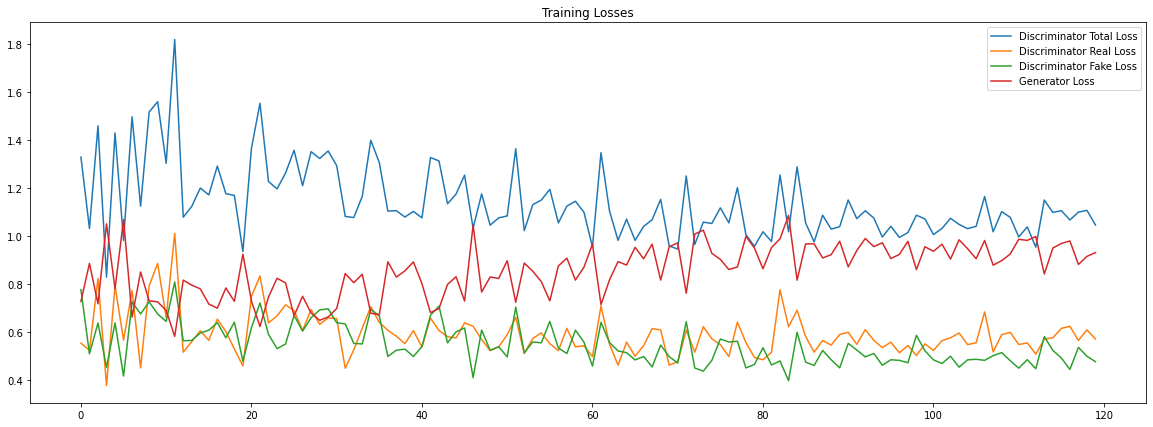

In [12]:
from Gan_tools import view_samples, view_process, adv_sample_legalization, loss_chart
loss_chart(losses)

# 显示图像

In [13]:
# Load samples from generator taken while training
with open('./gan_DeepFool_ckpt/train_samples.pkl', 'rb') as f:
    samples = pickle.load(f)

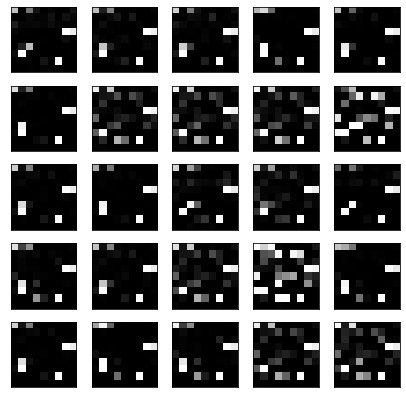

In [14]:
view_samples(samples, -1) # 显示最后一轮的outputs

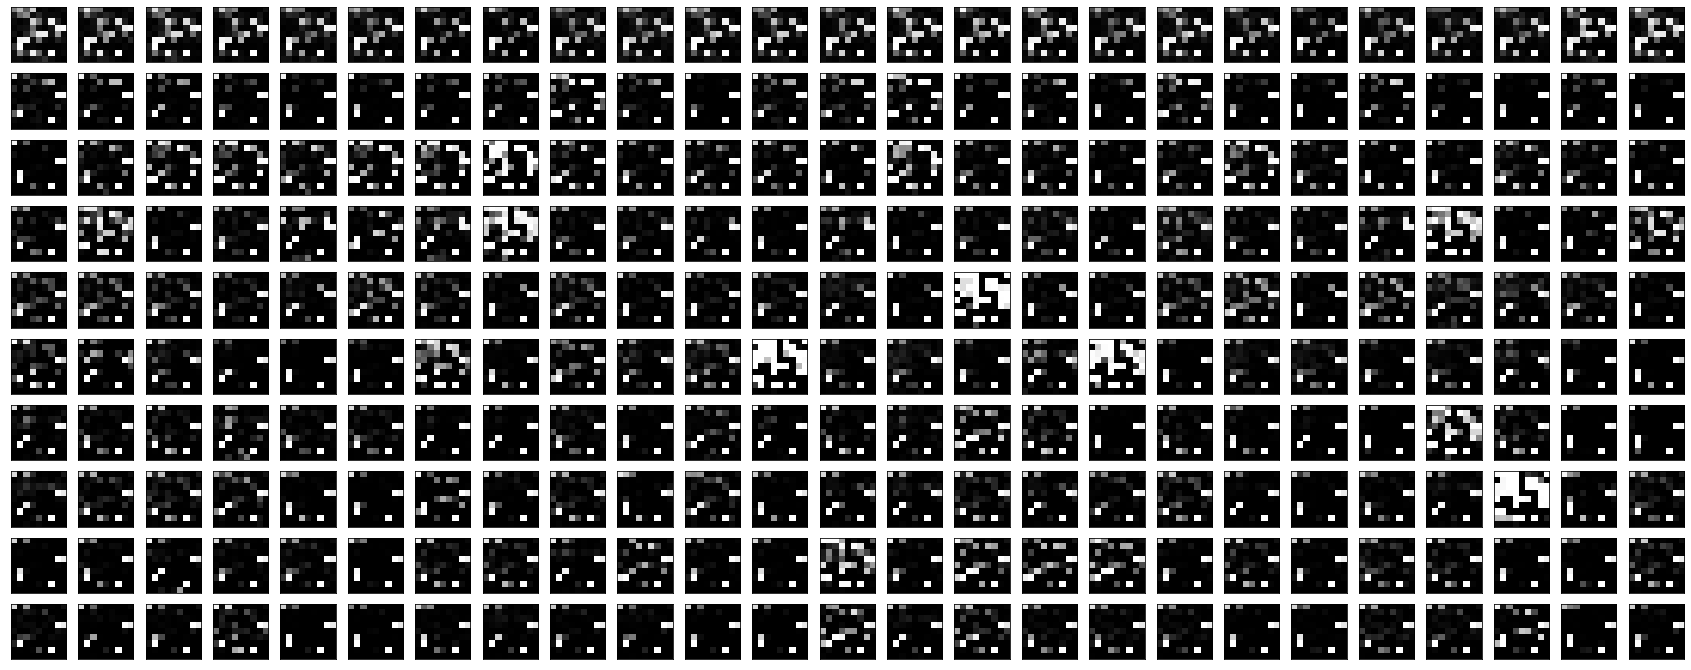

In [15]:
view_process(samples, 120)  # 显示整个生成过程图片

# 生成新的图片

In [16]:
# 加载我们的生成器变量
saver = tf.train.Saver(var_list=g_vars)
# print(g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('gan_DeepFool_ckpt'))
    sample_noise = np.random.uniform(-1, 1, size=(25, 10))
    # print(sample_noise)
    gen_samples = sess.run(get_generator(noise_img, img_size, g_units, reuse=True),
                           feed_dict={noise_img: sample_noise})
    
print(np.shape(gen_samples)) # (2, 25, 81)
# 第一个下标固定为1，代表选的是outputs，而不是logits；第二个下标范围为0-24，代表选择25个样本中的一个
test = gen_samples[1][0].tolist()
print(len(test))
print(test)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from gan_DeepFool_ckpt\all.ckpt
(2, 25, 81)
81
[-0.43273937702178955, -0.7474913001060486, -0.03671300783753395, -0.9808545112609863, -0.9540891647338867, -0.9777066707611084, -0.9980171918869019, -0.9968165755271912, -0.9400027990341187, -0.999467670917511, -0.980603814125061, -0.8521278500556946, -0.4697815179824829, -0.9362314939498901, -0.4750702381134033, -0.8195091485977173, -0.9996243119239807, -0.9998251795768738, -0.9947457313537598, -0.754515528678894, -0.9997926950454712, -0.9994293451309204, -1.0, -0.9991335272789001, -0.9693546295166016, -0.997016429901123, -0.9879089593887329, -0.8219954967498779, -0.9933016896247864, -0.9863540530204773, -0.9907702207565308, -0.9985692501068115, -0.9984521269798279, -0.9927246570587158, 0.9975354671478271, 0.786635160446167, -0.5154123306274414, -0.9844459891319275, -0.9998220801353455, -0.8507052659988403, -0.71158

In [17]:
# 将生成的对抗样本合法化
adv_sample_legalization(test)    

[[47859.15, 10624.32, 11.55, 12355558.83, 25.04, 20.05, 622.09, 16987.31, 286.75, 18.73, 74.23, 119.38, 1455.91, 36.74, 484.05, 453.36, 1117208.44, 2129856.51, 6308413.15, 526190.24, 11673195.73, 2160994.94, 1951804.99, 6060189.61, 1265174.0, 9111932.64, 1717341.55, 1335653.53, 3711296.22, 1106638.18, 0.05, 0.0, 0.0, 0.0, 3042819.44, 399650.76, 93717.21, 8426.98, 14.16, 1207.19, 235.93, 378.11, 663124.66, 0.01, 0.06, 0.0, 0.45, 0.55, 0.09, 0.0, 0.0, 0.74, 294.25, 75.47, 530.2, 3041626.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.95, 634.96, 27.8, 14062.47, 10751.11, 3683.38, 7.42, 399423.59, 102782.0, 39731.93, 169760.79, 73737.62, 4969712.85, 923218.95, 5629498.42, 4285629.83]]


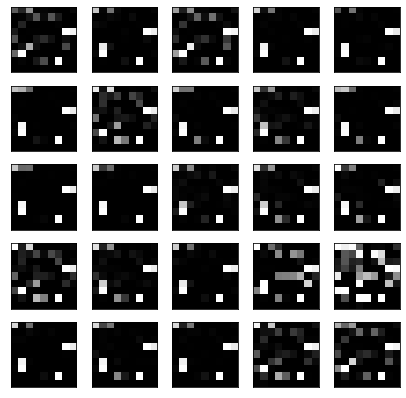

In [18]:
# 展示新生成的对抗样本图片
view_samples([gen_samples], 0)